## Importing Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import cv2
import shutil
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [41]:
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow import keras

## Reading Data

In [3]:
colon_dir=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
lung_dir=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
for i,d in enumerate([colon_dir,lung_dir]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if i==0:
        colon_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([colon_df, lung_df], axis =0).reset_index(drop=True)
df

,filepaths,labels
0,../input/lung-and-colon-cancer-histopathologic...,colon_aca
1,../input/lung-and-colon-cancer-histopathologic...,colon_aca
2,../input/lung-and-colon-cancer-histopathologic...,colon_aca
3,../input/lung-and-colon-cancer-histopathologic...,colon_aca
4,../input/lung-and-colon-cancer-histopathologic...,colon_aca
...,...,...
24995,../input/lung-and-colon-cancer-histopathologic...,lung_n
24996,../input/lung-and-colon-cancer-histopathologic...,lung_n
24997,../input/lung-and-colon-cancer-histopathologic...,lung_n
24998,../input/lung-and-colon-cancer-histopathologic...,lung_n


# EDA

**About Data**

This dataset contains 25,000 histopathological images of Human tissue with 5 classes. The dataset has been reduced to 100 images and 2 classes for this experiment.
The images were generated from an original sample of HIPAA compliant and validated sources. The images are collected by microscopic examination of a biopsy or surgical specimen that is processed and fixed onto glass slides.

The images in the dataset have a default size of 786x786 pixels.

In EDA, we've explored number of classes, data in each class and the pixel intesnity of images in each class. Moreover we've also visualized the data from each class.

**Class Data**

In [4]:
print("No of Unique Classes: ", len(set(df['labels'])))
print()
print(set(df['labels']))

No of Unique Classes:  5

{'colon_aca', 'colon_n', 'lung_scc', 'lung_aca', 'lung_n'}


In [5]:
number_classes = {}

for i in set(df['labels']):
    number_classes[i] = len(df[df['labels'] == i])

In [6]:
print(number_classes)

{'colon_aca': 5000, 'colon_n': 5000, 'lung_scc': 5000, 'lung_aca': 5000, 'lung_n': 5000}


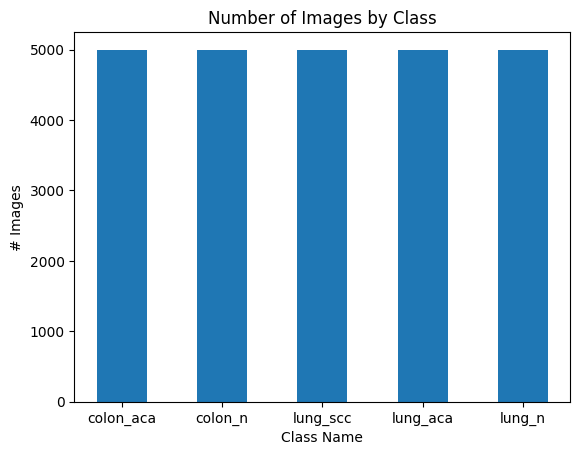

In [7]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

The dataset comprises of 5 classes. All classes have 5000 data points.

**Sample Images from each Class**

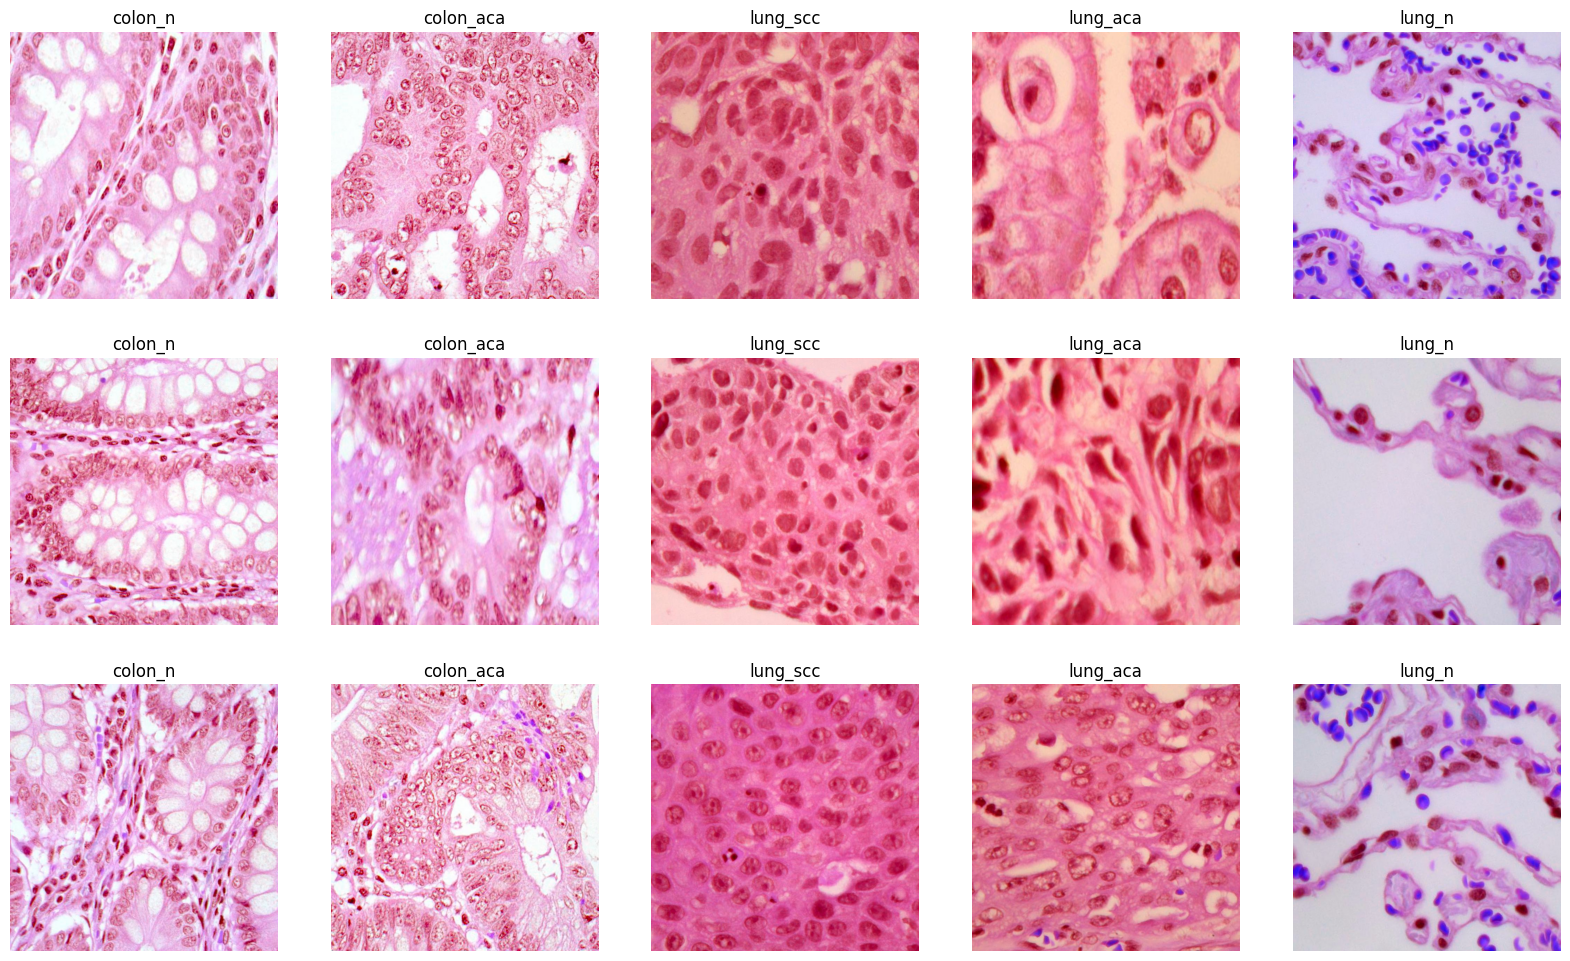

In [8]:
fig = plt.figure(figsize=(20, 12))

rows = 3
columns = 5

for i, j, k, l, m, n in zip(range(1,16, 5), df[df['labels'] == 'colon_n'].iloc[:3].iterrows(), df[df['labels'] == 'colon_aca'].iloc[:3].iterrows(), df[df['labels'] == 'lung_scc'].iloc[:3].iterrows(), df[df['labels'] == 'lung_aca'].iloc[:3].iterrows(), df[df['labels'] == 'lung_n'].iloc[:3].iterrows()):
    image1 = cv2.imread(j[1]['filepaths'])
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(image1)
    plt.axis('off')
    plt.title("colon_n")
    
    image2 = cv2.imread(k[1]['filepaths'])
    
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image2)
    plt.axis('off')
    plt.title("colon_aca")
    
    image3 = cv2.imread(l[1]['filepaths'])
    
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(image3)
    plt.axis('off')
    plt.title("lung_scc")
    
    
    image4 = cv2.imread(m[1]['filepaths'])
    
    fig.add_subplot(rows, columns, i+3)
    plt.imshow(image4)
    plt.axis('off')
    plt.title("lung_aca")
    
    image5 = cv2.imread(n[1]['filepaths'])
    
    fig.add_subplot(rows, columns, i+4)
    plt.imshow(image5)
    plt.axis('off')
    plt.title("lung_n")

**Graphical summaries of the pixel intensities of each channel**

In [9]:
stat = {}

for i in df.iterrows():
    im = Image.open(i[1]['filepaths'])
    
    try:
        stat[i[1]['labels']].append(ImageStat.Stat(im).mean)
    except KeyError:
        stat[i[1]['labels']]=[ImageStat.Stat(im).mean]

In [10]:
inten = []
channel = []
clas = []

for i in set(df['labels']):
        inten.append(np.array(stat[i])[:, 0].mean())
        inten.append(np.array(stat[i])[:, 1].mean())
        inten.append(np.array(stat[i])[:, 2].mean())
        channel.extend(['Red', 'Green', 'Blue'])
        clas.extend([i, i, i])

In [11]:
data = pd.DataFrame({
    'intensity': inten,
    'Channel': channel,
    'Class': clas
             })

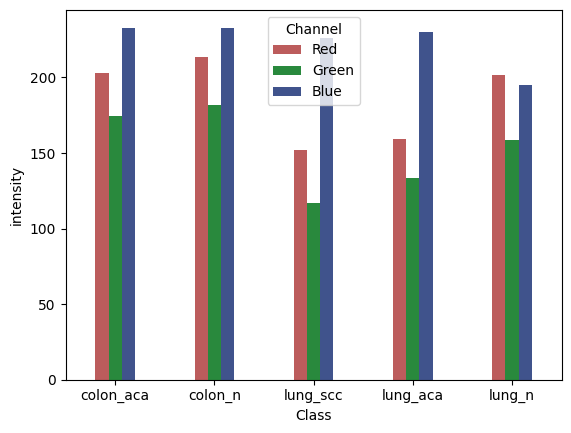

In [12]:
sns.barplot(x = 'Class',
            y = 'intensity',
            hue = 'Channel',
            data = data,
            palette = [[0.8, 0.3, 0.3], [0.1, 0.6, 0.2], [0.2, 0.3, 0.6] ],
            width=0.4)
 
plt.show()

# Preprocessing

In preprocessing we've split data into train, test and validation set. We've put this data into seprate folders.

In [4]:
# Spliting data into train validation and test set

x_train, x_test, y_train, y_test = train_test_split(df['filepaths'], df['labels'], test_size=1 - 0.80)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

<b> Copying Train, Test and Validation set images into their seperate folder <b>

In [5]:
os.mkdir('Datasets') 
os.mkdir('Datasets/train') 
os.mkdir('Datasets/test') 
os.mkdir('Datasets/val') 

In [6]:
for i in set(df['labels']):
    os.mkdir(os.path.join('Datasets/train', i))
    os.mkdir(os.path.join('Datasets/test', i))
    os.mkdir(os.path.join('Datasets/val', i))

In [7]:
for i, j in zip(x_train, y_train):
    shutil.copy(i, os.path.join(os.path.join('Datasets/train', j), i.split('/')[-1])) 
    
for i, j in zip(x_val, y_val):
    shutil.copy(i, os.path.join(os.path.join('Datasets/test', j), i.split('/')[-1])) 
    
for i, j in zip(x_test, y_test):
    shutil.copy(i, os.path.join(os.path.join('Datasets/val', j), i.split('/')[-1])) 

## Feature Engineering

In feature engineering we've performed real-time augmentation to increase the size of our data.

In [8]:
# Using ImageDataGenerator to augment data and then using flow_from_directory to load data into model

traaggin_path = 'Datasets/train'
valid_path = 'Datasets/test'
test_path = 'Datasets/val'
IMAGE_SIZE = [224, 224]

folders = glob('Datasets/train/*') 


train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(
                                                'Datasets/train',
                                                target_size = (224, 224),
                                                batch_size = 64,
                                                class_mode = 'categorical',
                                                classes=['colon_aca', 'lung_scc', 'lung_aca', 'colon_n', 'lung_n'],
                                                shuffle=False)
validation_set = validation_datagen.flow_from_directory('Datasets/val',
                                                target_size = (224, 224),
                                                batch_size = 64,
                                                class_mode = 'categorical',
                                                classes=['colon_aca', 'lung_scc', 'lung_aca', 'colon_n', 'lung_n'],
                                                shuffle=False)
test_set = test_datagen.flow_from_directory('Datasets/test',
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = 'categorical',
                                                classes=['colon_aca', 'lung_scc', 'lung_aca', 'colon_n', 'lung_n'],
                                                shuffle=False)

Found 20000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


# VGG 19 Training

We are conducting transfer learning on VGG19 for better performance on our data.

In [9]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output) 

prediction = Dense(len(folders), activation='softmax')(x) 

model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model_vgg.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 205s 590ms/step - loss: 1.4433 - accuracy: 0.7038 - val_loss: 0.2021 - val_accuracy: 0.9252
Epoch 2/5
313/313 [==============================] - 195s 606ms/step - loss: 0.3584 - accuracy: 0.8891 - val_loss: 0.1354 - val_accuracy: 0.9452
Epoch 3/5
313/313 [==============================] - 213s 660ms/step - loss: 0.4708 - accuracy: 0.8823 - val_loss: 0.2482 - val_accuracy: 0.9208
Epoch 4/5
313/313 [==============================] - 192s 602ms/step - loss: 0.3590 - accuracy: 0.9180 - val_loss: 0.1414 - val_accuracy: 0.9484
Epoch 5/5
313/313 [==============================] - 213s 666ms/step - loss: 0.2954 - accuracy: 0.9223 - val_loss: 0.1771 - val_accuracy: 0.9484


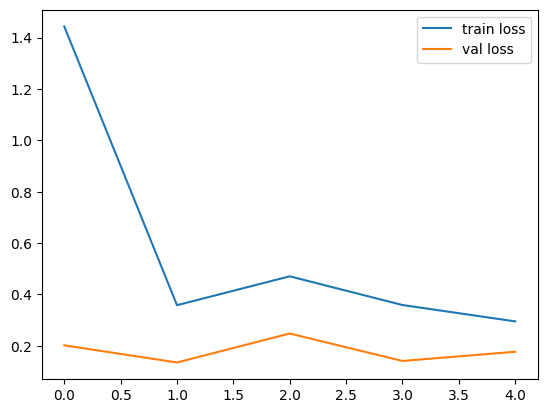

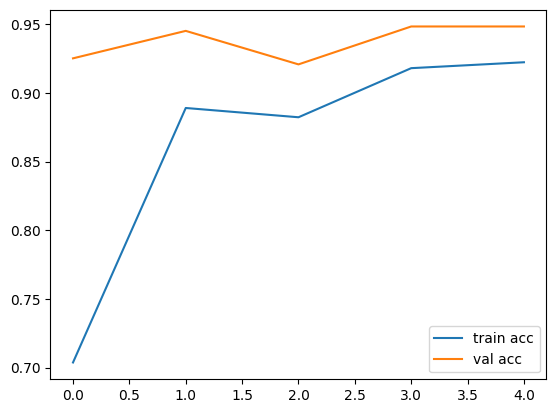

In [11]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [12]:
y_pred_vgg = model_vgg.predict(test_set)

79/79 [==============================] - 15s 191ms/step


In [13]:
print(classification_report(test_set.labels, np.argmax(y_pred_vgg, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       482
           1       0.86      0.99      0.92       529
           2       0.98      0.79      0.87       476
           3       0.98      1.00      0.99       500
           4       0.98      1.00      0.99       513

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



# ResNet50

We've tried making ResNet perform well on our data in 5 different ways but we've failed to do so. We did achieve train accuracy of 91 in one of our experiments but could not have validation accuracy of more than 53 with our test accuracy also not going above 54. We've tried changing optimizers, architecture and other hyperparameters of the model but have not found any success.

In [24]:
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in res.layers:
    layer.trainable = False
    
x = Flatten()(res.output) 

prediction = Dense(len(folders), activation='softmax')(x) 

model_res = Model(inputs=res.input, outputs=prediction)
model_res.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [25]:
model_res.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model_res.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 195s 597ms/step - loss: 8.0261 - accuracy: 0.2464 - val_loss: 3.0922 - val_accuracy: 0.3948
Epoch 2/5
313/313 [==============================] - 191s 600ms/step - loss: 7.6638 - accuracy: 0.3444 - val_loss: 2.2659 - val_accuracy: 0.4884
Epoch 3/5
313/313 [==============================] - 186s 578ms/step - loss: 8.1069 - accuracy: 0.4107 - val_loss: 2.6204 - val_accuracy: 0.5540
Epoch 4/5
313/313 [==============================] - 191s 597ms/step - loss: 4.4566 - accuracy: 0.4720 - val_loss: 6.1614 - val_accuracy: 0.4548
Epoch 5/5
313/313 [==============================] - 192s 602ms/step - loss: 4.5742 - accuracy: 0.4908 - val_loss: 4.2149 - val_accuracy: 0.5388


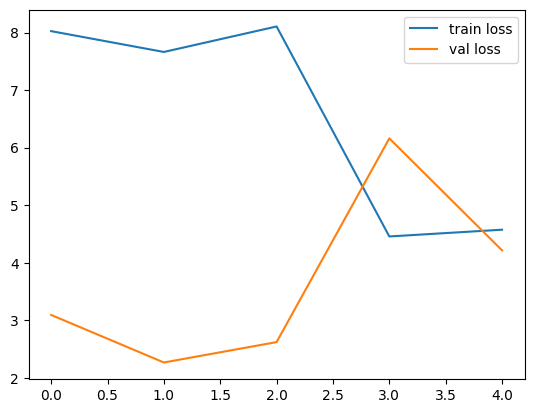

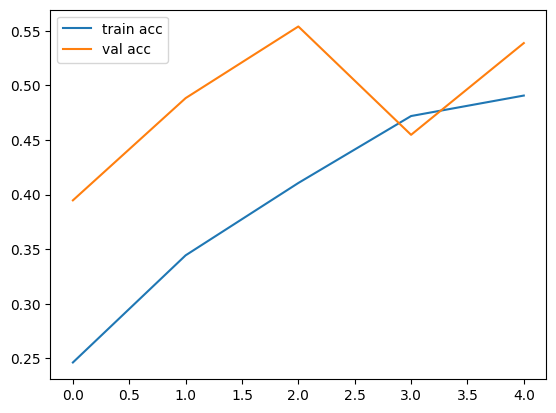

In [26]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [27]:
y_pred_res = model_res.predict(test_set)

79/79 [==============================] - 11s 123ms/step


In [28]:
print(classification_report(test_set.labels,np.argmax(y_pred_res, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.22      0.35       482
           1       0.82      0.53      0.65       529
           2       1.00      0.01      0.01       476
           3       0.55      0.92      0.69       500
           4       0.43      0.99      0.60       513

    accuracy                           0.54      2500
   macro avg       0.74      0.53      0.46      2500
weighted avg       0.74      0.54      0.47      2500



**Try 2** <br>
Changing the opimizer and trying again

In [29]:
res2 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in res2.layers:
    layer.trainable = False
    
res2_ouput = res2.output
    

x = GlobalAveragePooling2D()(res2_ouput)
x = Dense(512, activation='relu')(x)
x = Dense(len(folders), activation='softmax', name='fcnew')(x)
    
model_res2 = Model(inputs=res2.input, outputs=x)
model_res2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
model_res2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) 
history = model_res2.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 196s 601ms/step - loss: 1.6936 - accuracy: 0.2051 - val_loss: 1.6096 - val_accuracy: 0.1820
Epoch 2/5
313/313 [==============================] - 187s 585ms/step - loss: 1.6139 - accuracy: 0.1713 - val_loss: 1.6095 - val_accuracy: 0.2100
Epoch 3/5
313/313 [==============================] - 205s 643ms/step - loss: 1.6131 - accuracy: 0.1681 - val_loss: 1.6095 - val_accuracy: 0.2100
Epoch 4/5
313/313 [==============================] - 188s 583ms/step - loss: 1.6133 - accuracy: 0.1801 - val_loss: 1.6093 - val_accuracy: 0.1820
Epoch 5/5
313/313 [==============================] - 190s 597ms/step - loss: 1.6144 - accuracy: 0.1499 - val_loss: 1.6093 - val_accuracy: 0.1816


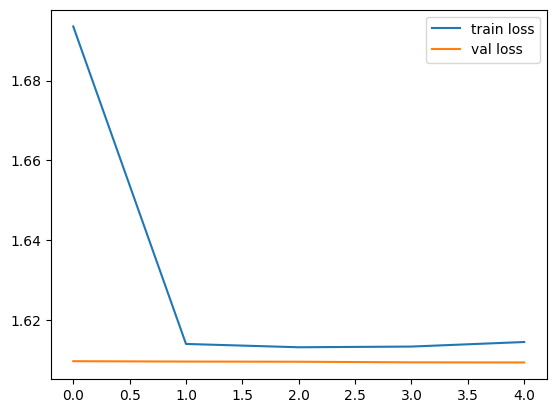

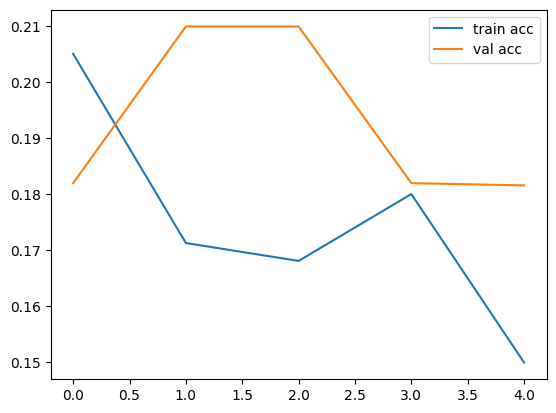

In [31]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [32]:
y_pred_res2 = model_res2.predict(test_set)

79/79 [==============================] - 11s 124ms/step


In [33]:
print(classification_report(test_set.labels,np.argmax(y_pred_res2, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       482
           1       0.00      0.00      0.00       529
           2       0.00      0.00      0.00       476
           3       0.20      1.00      0.33       500
           4       0.00      0.00      0.00       513

    accuracy                           0.20      2500
   macro avg       0.04      0.20      0.07      2500
weighted avg       0.04      0.20      0.07      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Fine Tuning ResNet**

Setting the last 140 layers of ResNet as trainable and trying again.

In [34]:
split_at = 140
for layer in model_res.layers[:split_at]: layer.trainable = False
for layer in model_res.layers[split_at:]: layer.trainable = True
    
model_res.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

model_res.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model_res.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 203s 606ms/step - loss: 19.2487 - accuracy: 0.2080 - val_loss: 1.6679 - val_accuracy: 0.2188
Epoch 2/5
313/313 [==============================] - 188s 588ms/step - loss: 1.6279 - accuracy: 0.2363 - val_loss: 1.6176 - val_accuracy: 0.2100
Epoch 3/5
313/313 [==============================] - 190s 596ms/step - loss: 1.6320 - accuracy: 0.2099 - val_loss: 1.6296 - val_accuracy: 0.1816
Epoch 4/5
313/313 [==============================] - 185s 572ms/step - loss: 1.6324 - accuracy: 0.2220 - val_loss: 1.6217 - val_accuracy: 0.1988
Epoch 5/5
313/313 [==============================] - 195s 604ms/step - loss: 1.6339 - accuracy: 0.1725 - val_loss: 1.6230 - val_accuracy: 0.1816


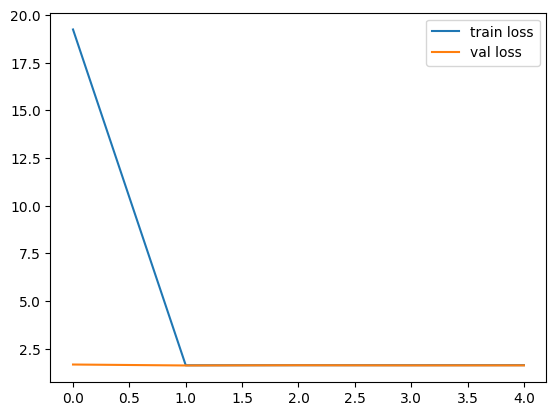

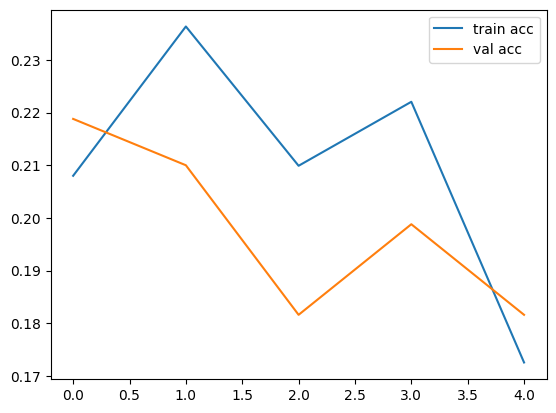

In [35]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [36]:
y_pred_res3 = model_res.predict(test_set)

79/79 [==============================] - 11s 128ms/step


In [37]:
print(classification_report(test_set.labels,np.argmax(y_pred_res3, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       482
           1       0.00      0.00      0.00       529
           2       0.00      0.00      0.00       476
           3       0.20      1.00      0.33       500
           4       0.00      0.00      0.00       513

    accuracy                           0.20      2500
   macro avg       0.04      0.20      0.07      2500
weighted avg       0.04      0.20      0.07      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Try 4**

Setting all layers as trainable and trying again.

In [ ]:
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    
# split_at = 140
# for layer in res.layers[:split_at]: layer.trainable = False
for layer in res.layers: layer.trainable = True
    
x = Flatten()(res.output) 

prediction = Dense(len(folders), activation='softmax')(x) 

model_res = Model(inputs=res.input, outputs=prediction)
# model_res.summary()

In [16]:
optimizer = keras.optimizers.Adam()
model_res.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model_res.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 287s 758ms/step - loss: 2.4989 - accuracy: 0.2652 - val_loss: 1.6686 - val_accuracy: 0.1956
Epoch 2/5
313/313 [==============================] - 234s 735ms/step - loss: 1.5584 - accuracy: 0.3293 - val_loss: 1.6089 - val_accuracy: 0.1988
Epoch 3/5
313/313 [==============================] - 233s 728ms/step - loss: 1.4365 - accuracy: 0.4248 - val_loss: 5.5485 - val_accuracy: 0.2100
Epoch 4/5
313/313 [==============================] - 232s 728ms/step - loss: 1.9566 - accuracy: 0.5583 - val_loss: 70.1743 - val_accuracy: 0.2940
Epoch 5/5
313/313 [==============================] - 231s 726ms/step - loss: 1.4871 - accuracy: 0.6409 - val_loss: 8542.5029 - val_accuracy: 0.2216


In [20]:
model_res.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_res.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 251s 725ms/step - loss: 1.1949 - accuracy: 0.6824 - val_loss: 5.6670 - val_accuracy: 0.4608
Epoch 2/5
313/313 [==============================] - 230s 722ms/step - loss: 0.4898 - accuracy: 0.8712 - val_loss: 7.0923 - val_accuracy: 0.2780
Epoch 3/5
313/313 [==============================] - 232s 723ms/step - loss: 0.3346 - accuracy: 0.9104 - val_loss: 5.5438 - val_accuracy: 0.2096
Epoch 4/5
313/313 [==============================] - 230s 722ms/step - loss: 0.2499 - accuracy: 0.9402 - val_loss: 10.9414 - val_accuracy: 0.2860
Epoch 5/5
313/313 [==============================] - 231s 726ms/step - loss: 0.1391 - accuracy: 0.9672 - val_loss: 13.4830 - val_accuracy: 0.3180


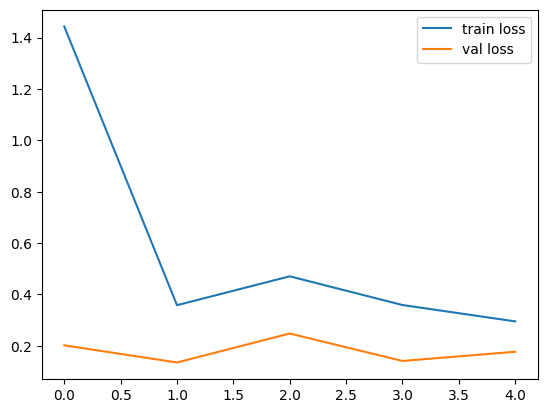

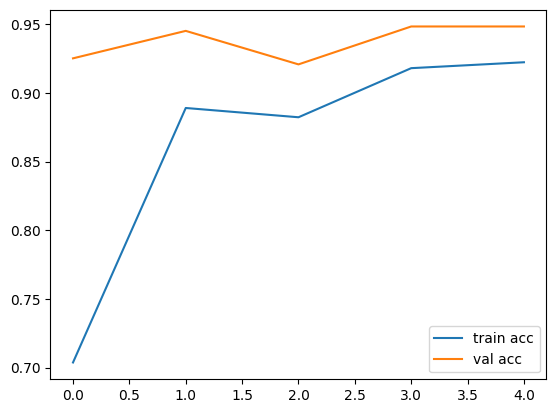

In [21]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [22]:
y_pred_res4 = model_res.predict(test_set)

79/79 [==============================] - 11s 129ms/step


In [23]:
print(classification_report(test_set.labels,np.argmax(y_pred_res4, axis=1)))

              precision    recall  f1-score   support

           0       0.24      0.93      0.38       482
           1       0.54      0.13      0.21       529
           2       0.36      0.28      0.31       476
           3       0.00      0.00      0.00       500
           4       0.80      0.14      0.23       513

    accuracy                           0.29      2500
   macro avg       0.39      0.30      0.23      2500
weighted avg       0.39      0.29      0.22      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Try 5**

Changing the architecture and trying again.

In [61]:
import tensorflow
pretrained_resnet_base = tensorflow.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tensorflow.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(tensorflow.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(5, activation="softmax")
])


In [62]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_res.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5
313/313 [==============================] - 184s 569ms/step - loss: 1.6381 - accuracy: 0.1716 - val_loss: 1.6197 - val_accuracy: 0.1988
Epoch 2/5
313/313 [==============================] - 188s 590ms/step - loss: 1.6322 - accuracy: 0.1722 - val_loss: 1.6460 - val_accuracy: 0.1912
Epoch 3/5
313/313 [==============================] - 191s 598ms/step - loss: 1.6368 - accuracy: 0.2044 - val_loss: 1.6132 - val_accuracy: 0.1988
Epoch 4/5
313/313 [==============================] - 183s 571ms/step - loss: 1.6359 - accuracy: 0.1833 - val_loss: 1.6228 - val_accuracy: 0.2100
Epoch 5/5
313/313 [==============================] - 193s 604ms/step - loss: 1.6369 - accuracy: 0.1864 - val_loss: 1.6177 - val_accuracy: 0.2184


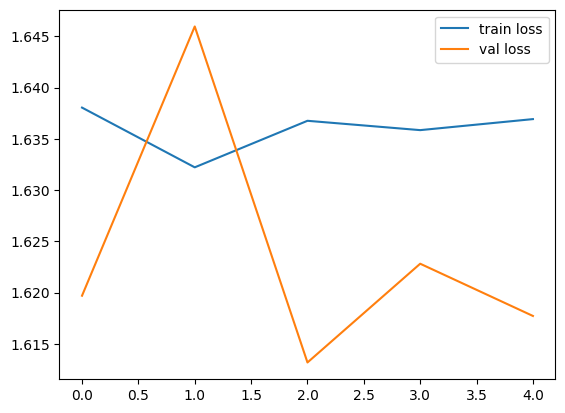

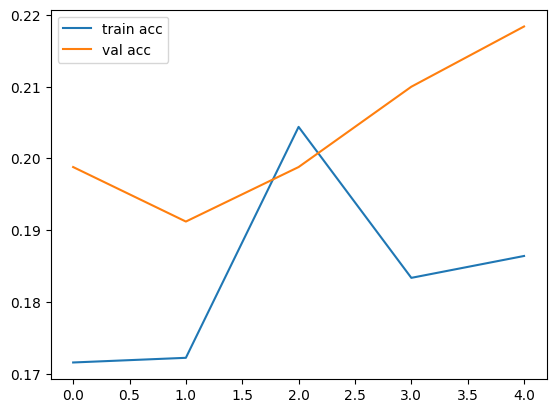

In [63]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [64]:
y_pred_res5 = resnet_model.predict(test_set)

79/79 [==============================] - 10s 117ms/step


In [65]:
print(classification_report(test_set.labels,np.argmax(y_pred_res5, axis=1)))

              precision    recall  f1-score   support

           0       0.19      0.96      0.32       482
           1       0.22      0.04      0.06       529
           2       0.00      0.00      0.00       476
           3       0.00      0.00      0.00       500
           4       0.00      0.00      0.00       513

    accuracy                           0.19      2500
   macro avg       0.08      0.20      0.08      2500
weighted avg       0.08      0.19      0.07      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# EfficientNet

Just like ResNet, EfficientNet was also another huge disappointment. We could not achieve any meaningful results and dropped the model from our ensemble configuration. We tried 2 different architecture layers but did not find any success.

In [51]:
enet = EfficientNetV2B0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enet.layers:
    layer.trainable = False
    
x = Flatten()(enet.output) 

prediction = Dense(len(folders), activation='softmax')(x) 

model_enet = Model(inputs=enet.input, outputs=prediction)
model_enet.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)        

In [52]:
model_enet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model_enet.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5


2023-12-05 15:44:23.055782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 187s 554ms/step - loss: 10.9051 - accuracy: 0.2077 - val_loss: 11.9926 - val_accuracy: 0.1912
Epoch 2/5
313/313 [==============================] - 180s 561ms/step - loss: 10.0948 - accuracy: 0.1673 - val_loss: 18.7368 - val_accuracy: 0.2100
Epoch 3/5
313/313 [==============================] - 187s 587ms/step - loss: 9.0425 - accuracy: 0.2048 - val_loss: 4.6989 - val_accuracy: 0.2100
Epoch 4/5
313/313 [==============================] - 190s 589ms/step - loss: 8.8197 - accuracy: 0.2005 - val_loss: 9.6242 - val_accuracy: 0.2096
Epoch 5/5
313/313 [==============================] - 189s 591ms/step - loss: 11.0700 - accuracy: 0.2067 - val_loss: 7.5447 - val_accuracy: 0.1992


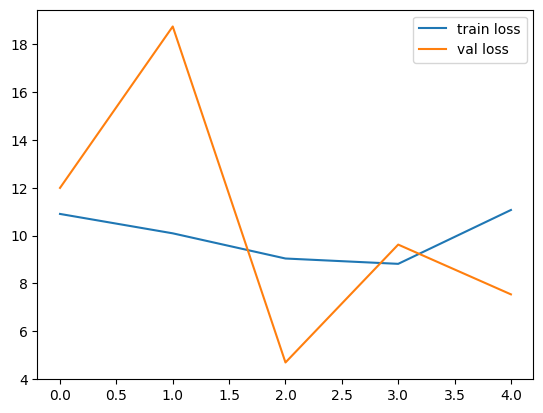

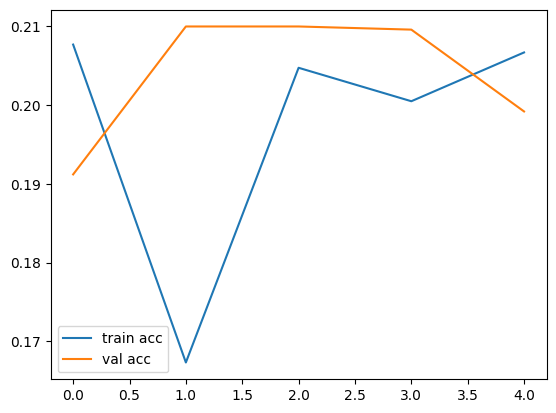

In [53]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [54]:
y_pred_enet = model_enet.predict(test_set)

79/79 [==============================] - 12s 127ms/step


In [55]:
print(classification_report(test_set.labels,np.argmax(y_pred_enet, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       482
           1       0.00      0.00      0.00       529
           2       0.00      0.00      0.00       476
           3       0.24      1.00      0.38       500
           4       0.12      0.09      0.10       513

    accuracy                           0.22      2500
   macro avg       0.07      0.22      0.10      2500
weighted avg       0.07      0.22      0.10      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Try 2**

Traying again with a different architecutre.

In [66]:
prerained_efficientnet_base = tensorflow.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tensorflow.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(5, activation="softmax")
])

In [67]:
efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = efficientnet_model.fit(training_set, validation_data=validation_set, epochs=5, batch_size=32, use_multiprocessing=True, workers=8)

Epoch 1/5


2023-12-05 16:31:55.232222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 195s 574ms/step - loss: 1.6663 - accuracy: 0.2136 - val_loss: 1.6095 - val_accuracy: 0.1988
Epoch 2/5
313/313 [==============================] - 186s 581ms/step - loss: 1.6104 - accuracy: 0.1893 - val_loss: 1.6095 - val_accuracy: 0.1988
Epoch 3/5
313/313 [==============================] - 185s 574ms/step - loss: 1.6103 - accuracy: 0.1863 - val_loss: 1.6096 - val_accuracy: 0.1912
Epoch 4/5
313/313 [==============================] - 185s 570ms/step - loss: 1.6105 - accuracy: 0.1412 - val_loss: 1.6096 - val_accuracy: 0.1912
Epoch 5/5
313/313 [==============================] - 184s 571ms/step - loss: 1.6104 - accuracy: 0.1753 - val_loss: 1.6096 - val_accuracy: 0.1988


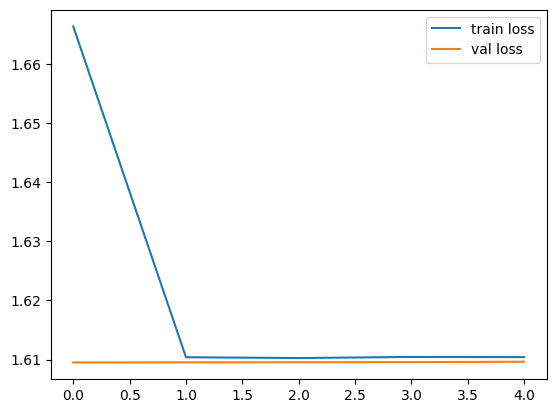

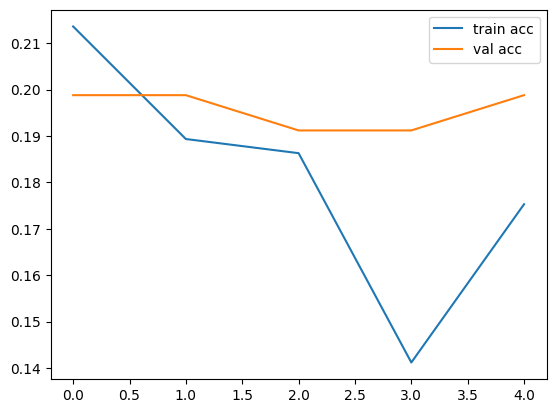

In [68]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [69]:
y_pred_enet2 = efficientnet_model.predict(test_set)

79/79 [==============================] - 13s 122ms/step


In [70]:
print(classification_report(test_set.labels,np.argmax(y_pred_enet2, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       482
           1       0.21      1.00      0.35       529
           2       0.00      0.00      0.00       476
           3       0.00      0.00      0.00       500
           4       0.00      0.00      0.00       513

    accuracy                           0.21      2500
   macro avg       0.04      0.20      0.07      2500
weighted avg       0.04      0.21      0.07      2500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ensembling

Employing majority voting for classification.

In [71]:
def most_frequent(List):
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    return unique[index]

In [72]:
y_pred_ens = []

for i, j, k in zip(np.argmax(y_pred_vgg, axis=1), np.argmax(y_pred_res, axis=1), np.argmax(y_pred_enet, axis=1)):
    y_pred_ens.append(most_frequent([i, j, k]))

In [73]:
print(classification_report(test_set.labels, y_pred_ens))

              precision    recall  f1-score   support

           0       0.92      0.36      0.52       482
           1       0.81      0.83      0.82       529
           2       0.98      0.61      0.75       476
           3       0.57      1.00      0.72       500
           4       0.86      0.99      0.92       513

    accuracy                           0.76      2500
   macro avg       0.83      0.76      0.74      2500
weighted avg       0.82      0.76      0.75      2500



**Trying with 2 models**

Removing outputs of EfficientNet as it has really low accuracy.

In [74]:
y_pred_ens = []

for i, j in zip(np.argmax(y_pred_vgg, axis=1), np.argmax(y_pred_res, axis=1)):
    y_pred_ens.append(most_frequent([i, j]))

In [75]:
print(classification_report(test_set.labels, y_pred_ens))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       482
           1       0.82      0.98      0.89       529
           2       0.98      0.73      0.84       476
           3       0.98      0.99      0.99       500
           4       0.98      0.99      0.98       513

    accuracy                           0.93      2500
   macro avg       0.94      0.93      0.93      2500
weighted avg       0.94      0.93      0.93      2500

